### Loads test data in numpy format and 2D folders for running predictions

In [1]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import helpers as H
from tqdm import tqdm
from fastMRI.data import transforms as T
from fastMRI.common.subsample import MaskFunc

#Root directory of the project
ROOT_DIR = os.path.abspath(".")
TEST_DATASET_PATH = os.path.join(ROOT_DIR, "dataset")
test_h5_files = glob.glob(os.path.join(TEST_DATASET_PATH,'singlecoil_test_v2','*.h5'))
print(len(test_h5_files))

108


In [2]:
def sub_sample_kspace(vol, mask_func):
    """
    Transform a kpsace tensor to an undersampled 3D image using mask object 4x or 8x.
    Args:
        vol: kspace tensor
        mask_func: mask function object (4x, 8x)
    Returns:
        sampled_image: output undersampled 3D image volume
    """
    
    # 1. convert numpy to torch tensor
    kspace2ttensor = T.to_tensor(vol)
    
    ### NO MASKING IN TEST DATA AS IT IS ALREADY UNDERSAMPLED
    # 2. apply mask to kspace
    #masked_kspace, mask = T.apply_mask(kspace2ttensor, mask_func)   
    
    # 3. inverse fast fourier transform 2D
    sampled_image = T.ifft2(kspace2ttensor)
    
    # 4. compute absolute value to get a real image
    sampled_image_abs = T.complex_abs(sampled_image)
    
    # 5. centre crop to 320x320
    cropped_image = T.center_crop(sampled_image_abs, (320, 320))
    
    # 6. Normalize
    #cropped_image_norm, _, _ = T.normalize_instance(cropped_image)

    # 7. convert torch tensor to good old numpy array
    sampled_image = np.abs(cropped_image.numpy())
    
    return sampled_image


def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

### Get a single MRI file from test set

In [3]:
test_h5_files[0]

'E:\\FastMRI\\MRI-reconstruction\\dataset\\singlecoil_test_v2\\file1000022_v2.h5'

In [4]:
file = test_h5_files[0]
hf = h5py.File(file)
print(type(hf))

<class 'h5py._hl.files.File'>


In [5]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'acquisition': 'CORPDFS_FBK', 'num_low_frequency': 15, 'patient_id': 'e24dd3dc05085077e65af05fc5d4c439e5e338e58926c4f344274080bd7f7cdd'}


In [6]:
mask = hf['mask']
mask

<HDF5 dataset "mask": shape (368,), type "|b1">

In [7]:
# Create a mask function object for undersampling
#mask_func = MaskFunc(center_fractions=[0.04, 0.08], accelerations=[8, 4])
#mask_func

### 1. Kspace tensor

In [8]:
kspace_tensor = hf['kspace'][()]
print(kspace_tensor.shape)
img_3d = sub_sample_kspace(kspace_tensor, _)
print(img_3d.shape)

(37, 640, 368)
(37, 320, 320)


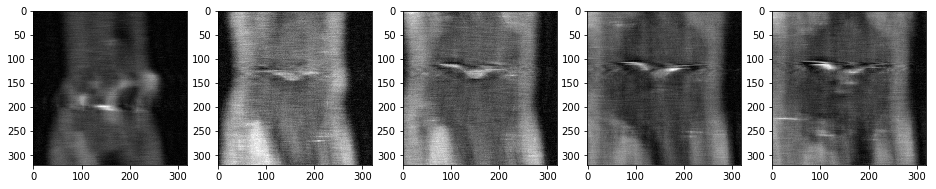

In [9]:
slice_num = [12, 16, 19, 22, 24]
show_slices(img_3d, slice_num, cmap='gray')

3.993269e-09 0.0001165337


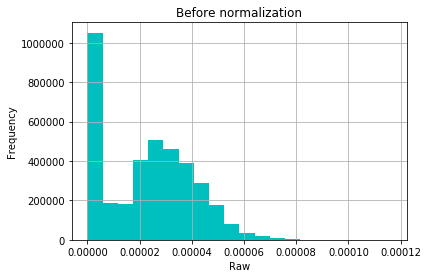

In [10]:
img_flat = img_3d.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [11]:
a = H.normalize(img_3d)
a.shape

(37, 320, 320)

0.0 1.0


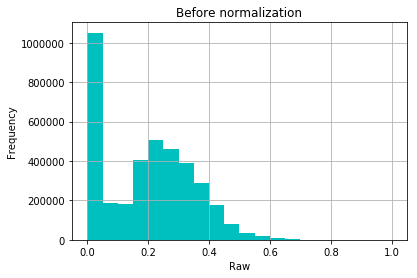

In [12]:
img_flat = a.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [13]:
# go back to original distribution
c = a * 0.0001165337 - 3.993269e-09
c.shape

(37, 320, 320)

-3.993269e-09 0.00011652971


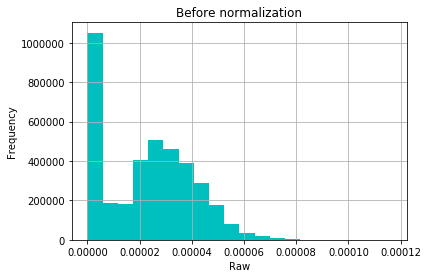

In [14]:
img_flat = c.flatten()
print(min(img_flat), max(img_flat))
plt.hist(img_flat, bins=20, color='c')
plt.title("Before normalization")
plt.xlabel("Raw")
plt.grid(True)
plt.ylabel("Frequency")
plt.show()

In [10]:
TEST_LOW_DIR = "singlecoil_test_3D_images/"
H.create_directory("{}/{}".format(TEST_DATASET_PATH, TEST_LOW_DIR))

In [11]:
TEST_IMAGES_DIR_PATH = os.path.join(TEST_DATASET_PATH, TEST_LOW_DIR)
TEST_IMAGES_DIR_PATH

'/home/hasib/MRI-reconstruction/dataset/singlecoil_test_3D_images/'

In [12]:
len(test_h5_files)

2

In [13]:
test_h5_files[:5]

['/home/hasib/MRI-reconstruction/dataset/singlecoil_test_v2/file1000022_v2.h5',
 '/home/hasib/MRI-reconstruction/dataset/singlecoil_test_v2/file1000036_v2.h5']

In [14]:
i=0
for file in tqdm(test_h5_files[:]):
    i+=1
    
    hf = h5py.File(file)
    
    # transform and save low res image volume
    kspace_tensor = hf['kspace'][()]
    img_3d = sub_sample_kspace(kspace_tensor, _)
    
    # Save 
    np.save("{}/f{}.npy".format(TEST_IMAGES_DIR_PATH, file[-16:-3]), img_3d)

    # Show progress
    #print(i, file, "raw data - ", kspace_tensor.shape, "--", "input test volume - ", img_3d.shape)
    

100%|██████████| 2/2 [00:01<00:00,  1.80it/s]


### Sanity check

In [15]:
len(os.listdir(TEST_IMAGES_DIR_PATH))

2

In [16]:
os.listdir(TEST_IMAGES_DIR_PATH)[:3]

['file1000036_v2.npy', 'file1000022_v2.npy']

In [17]:
print("Done!")

Done!


In [18]:
TEST_IMAGES_DIR_PATH

'/home/hasib/MRI-reconstruction/dataset/singlecoil_test_3D_images/'

In [19]:
ALL_3D_TEST_PATHS = ["{}/{}".format(TEST_IMAGES_DIR_PATH,l) for l in os.listdir(TEST_IMAGES_DIR_PATH)]
len(ALL_3D_TEST_PATHS)

2

In [20]:
ALL_3D_TEST_PATHS[0]

'/home/hasib/MRI-reconstruction/dataset/singlecoil_test_3D_images//file1000036_v2.npy'

In [21]:
TEST_VOL_FOLDER_PATH = os.path.join(TEST_DATASET_PATH, TEST_LOW_DIR, "")

In [23]:
#H.create_directory()